# Exploration

Here we perform some basic exploration of the SECOP II dataset in order to get basic insights and get some ideas on how to process the data for training the model.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re

from sklearn.feature_extraction.text import CountVectorizer

np.random.seed(987)
plt.style.use("seaborn")

# Data Loading

In [2]:
raw_file = os.path.join("..", "data", "raw", "raw_data.csv")
df_raw = pd.read_csv(raw_file)

print(df_raw.shape)
print(df_raw.columns)

df_raw.head()

(500000, 2)
Index(['descripcion_del_proceso', 'codigo_de_categoria_principal'], dtype='object')


,descripcion_del_proceso,codigo_de_categoria_principal
0,Prestar los servicios profesionales de apoyo j...,V1.77101604
1,CONTRATAR EL SERVICIO DE GESTIÓN DE EVENTOS O ...,V1.90101604
2,Censo_Economico_2021_SECGEN_BDMGN_TH Prestació...,V1.80111500
3,PRESTAR SERVICIOS DE CARÁCTER TEMPORAL COMO IN...,V1.80111600
4,AUNAR ESFUERZOS ENTRE EL DEPARTAMENTO Y EL MUN...,V1.72141003


In [3]:
#We'll use a sample of our dataset to reduce data allocation.

df_sample = df_raw.sample(10000).reset_index().drop(columns='index')

In [4]:
pd.isnull(df_sample).sum()

descripcion_del_proceso          0
codigo_de_categoria_principal    0
dtype: int64

As we can see, there are no entries without description or UNSPSC code.

#  Load UNSPSC Codes References

In [5]:
unspsc_file = os.path.join("..","references","UNSPSC Codes Reference.xlsx")
df_unspsc = pd.read_excel(unspsc_file)

print(df_unspsc.shape)
print(df_unspsc.columns)

df_unspsc.head()

(4295, 8)
Index(['Commodity Code', 'Commodity Title', 'Class Code', 'Class Title',
       'Family Code', 'Family Title', 'Segment Code', 'Segment Title'],
      dtype='object')


,Commodity Code,Commodity Title,Class Code,Class Title,Family Code,Family Title,Segment Code,Segment Title
0,10111302,Pet grooming products,10111300,Domestic pet treatments and accessories and eq...,10110000,Domestic pet products,10000000,Live Plant and Animal Material and Accessories...
1,10111306,Domestic pet training kits,10111300,Domestic pet treatments and accessories and eq...,10110000,Domestic pet products,10000000,Live Plant and Animal Material and Accessories...
2,10131601,Cages or its accessories,10131600,Animal containment,10130000,Animal containment and habitats,10000000,Live Plant and Animal Material and Accessories...
3,10131602,Kennels,10131600,Animal containment,10130000,Animal containment and habitats,10000000,Live Plant and Animal Material and Accessories...
4,10131605,Animal transport cage,10131600,Animal containment,10130000,Animal containment and habitats,10000000,Live Plant and Animal Material and Accessories...


In [6]:
commodity_dict = dict(
    zip(
        df_unspsc['Commodity Code'],df_unspsc['Commodity Title']
    )
)
class_dict = dict(
    zip(
        df_unspsc['Class Code'].astype('str').str.extract('([0-9]{6})', expand=False),
        df_unspsc['Class Title']
    )
)
family_dict = dict(
    zip(
        df_unspsc['Family Code'].astype('str').str.extract('([0-9]{4})', expand=False),
        df_unspsc['Family Title']
    )
)
segment_dict = dict(
    zip(
        df_unspsc['Segment Code'].astype('str').str.extract('([0-9]{2})', expand=False),
        df_unspsc['Segment Title']
    )
)

# Transform UNSPSC codes to topics

In [7]:
df_sample['codigo_de_categoria_principal'] = df_sample['codigo_de_categoria_principal'].str.extract('([0-9]{8})', expand=False)

df_sample['segment_code'] = df_sample['codigo_de_categoria_principal'].str.extract('([0-9]{2})', expand=False)
df_sample['family_code'] = df_sample['codigo_de_categoria_principal'].str.extract('([0-9]{2,4})', expand=False)
df_sample['class_code'] = df_sample['codigo_de_categoria_principal'].str.extract('([0-9]{4,6})', expand=False)
df_sample['commodity_code'] = df_sample['codigo_de_categoria_principal'].str.extract('([0-9]{6,8})', expand=False)

df_sample.head()

,descripcion_del_proceso,codigo_de_categoria_principal,segment_code,family_code,class_code,commodity_code
0,SUMINISTRO DE MEDICAMENTOS AMBULATORIOS PARA L...,51101500,51,5110,511015,51101500
1,Prestar con plena autonomía técnica y administ...,86141704,86,8614,861417,86141704
2,Prestación de Servicios Profesionales como Abo...,80111501,80,8011,801115,80111501
3,PRESTAR SERVICIOS PROFESIONALES DE CARÁCTER TE...,80111600,80,8011,801116,80111600
4,Prestar servicios personales de carácter tempo...,86101710,86,8610,861017,86101710


In [8]:
df_sample['segment_text'] = df_sample.segment_code.replace(segment_dict).str.extract('([^0-9]+)')
df_sample['family_text'] = df_sample.family_code.replace(family_dict).str.extract('([^0-9]+)')
df_sample['class_text'] = df_sample.class_code.replace(class_dict).str.extract('([^0-9]+)')
df_sample['commodity_text'] = df_sample.commodity_code.replace(commodity_dict).str.extract('([^0-9]+)')

df_sample.head(10)

,descripcion_del_proceso,codigo_de_categoria_principal,segment_code,family_code,class_code,commodity_code,segment_text,family_text,class_text,commodity_text
0,SUMINISTRO DE MEDICAMENTOS AMBULATORIOS PARA L...,51101500,51,5110,511015,51101500,Drugs and Pharmaceutical Products,NaN,NaN,NaN
1,Prestar con plena autonomía técnica y administ...,86141704,86,8614,861417,86141704,NaN,NaN,NaN,NaN
2,Prestación de Servicios Profesionales como Abo...,80111501,80,8011,801115,80111501,NaN,NaN,NaN,NaN
3,PRESTAR SERVICIOS PROFESIONALES DE CARÁCTER TE...,80111600,80,8011,801116,80111600,NaN,NaN,NaN,NaN
4,Prestar servicios personales de carácter tempo...,86101710,86,8610,861017,86101710,NaN,NaN,NaN,NaN
5,Entregar a título de comodato a la Policía Nac...,95101800,95,9510,951018,95101800,Land and Buildings and Structures and Thorough...,NaN,NaN,NaN
6,PRESTACIÓN DE SERVICIOS PROFESIONALES COMO PSI...,80111600,80,8011,801116,80111600,NaN,NaN,NaN,NaN
7,Apoyar a la Dirección de Infraestructura Socia...,80111600,80,8011,801116,80111600,NaN,NaN,NaN,NaN
8,FORTALECER LA GESTIÓN DEL MODELO DE ATENCIÓN ...,85101605,85,8510,851016,85101605,NaN,NaN,NaN,NaN
9,PRESTACIÓN DE SERVICIOS DE APOYO A LA GESTIÓN ...,85101600,85,8510,851016,85101600,NaN,NaN,NaN,NaN


In [9]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   descripcion_del_proceso        10000 non-null  object
 1   codigo_de_categoria_principal  9982 non-null   object
 2   segment_code                   9982 non-null   object
 3   family_code                    9982 non-null   object
 4   class_code                     9982 non-null   object
 5   commodity_code                 9982 non-null   object
 6   segment_text                   1106 non-null   object
 7   family_text                    717 non-null    object
 8   class_text                     389 non-null    object
 9   commodity_text                 0 non-null      object
dtypes: object(10)
memory usage: 781.4+ KB


Here we can see that theres a lot of codes without a topic representation. So it's better keep making the analysis with the codes instead of his text representations

# Description Lenght Exploration

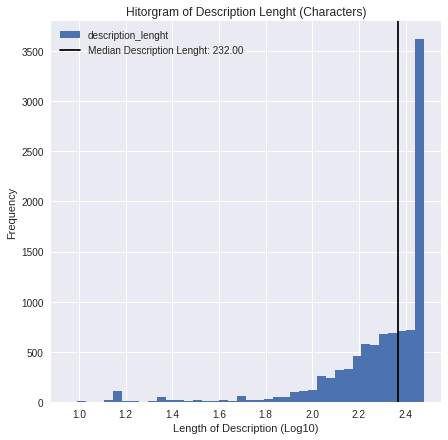

In [10]:
df_sample["description_lenght"] = df_sample.descripcion_del_proceso.map(len)

fig, ax = plt.subplots(figsize=(7, 7))
lens_log10 = df_sample["description_lenght"].map(np.log10)
lens_log10.plot.hist(bins=40, ax=ax)

median_len = lens_log10.median()
ax.axvline(median_len, label=f"Median Description Lenght: {10 ** median_len:0.2f}", color="black")

ax.set_title("Hitorgram of Description Lenght (Characters)")
ax.set_xlabel("Length of Description (Log10)")
ax.legend()
plt.show()

From these basic histograms of description texts, we can see that mosk contracts texts are rather short, with a median description length of around 232 characters (10 ^ 2,36). This in turn corresponds to around 35 - 45 words.

# Segments explorations

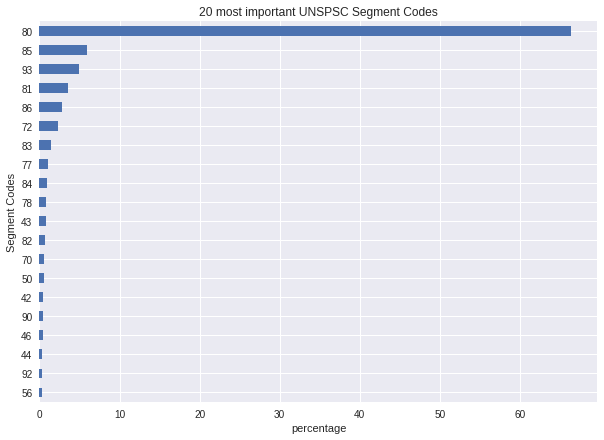

In [28]:
plt.figure(figsize=(10,7))
plt.title('20 most important UNSPSC Segment Codes')
plt.ylabel('Segment Codes')
plt.xlabel('percentage')
(100*df_sample.segment_code.value_counts(normalize=True)).iloc[:20].sort_values().plot(kind = 'barh');

This plot shows us that we have a unbalanced dataset, where the majority of the UNSPSC codes are in 80 Segment

# Family explorations

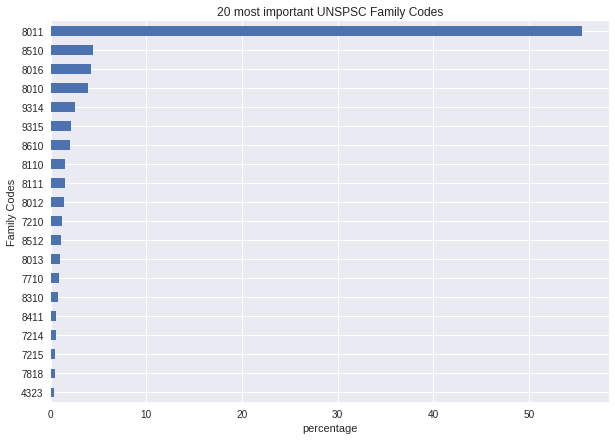

In [29]:
plt.figure(figsize=(10,7))
plt.title('20 most important UNSPSC Family Codes')
plt.ylabel('Family Codes')
plt.xlabel('percentage')
(100*df_sample.family_code.value_counts(normalize=True)).iloc[:20].sort_values().plot(kind = 'barh');

# Class explorations

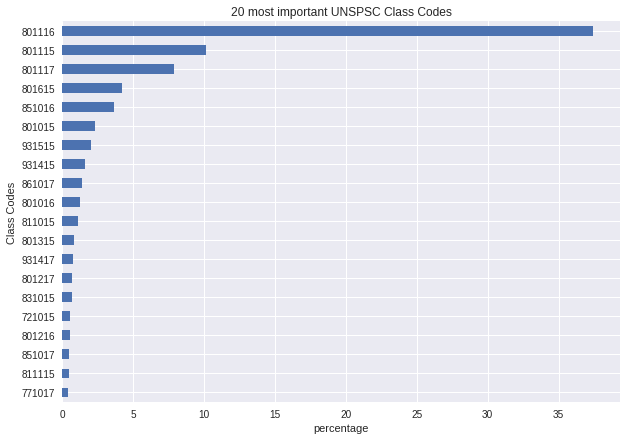

In [30]:
plt.figure(figsize=(10,7))
plt.title('20 most important UNSPSC Class Codes')
plt.ylabel('Class Codes')
plt.xlabel('percentage')
(100*df_sample.class_code.value_counts(normalize=True)).iloc[:20].sort_values().plot(kind = 'barh');

# Commodity explorations

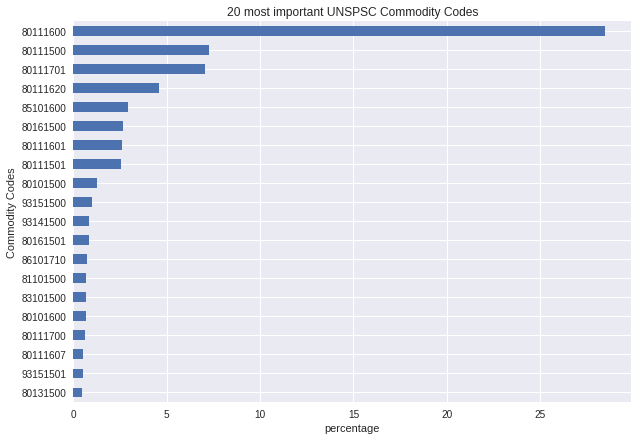

In [31]:
plt.figure(figsize=(10,7))
plt.title('20 most important UNSPSC Commodity Codes')
plt.ylabel('Commodity Codes')
plt.xlabel('percentage')
(100*df_sample.commodity_code.value_counts(normalize=True)).iloc[:20].sort_values().plot(kind = 'barh');

# Text Standarization

Now we take a quick look at one of the contracts bodies to get a better idea of what we are dealing with.

In [18]:
# Definimos los tokenizer y lemmatizer
wpt = nltk.WordPunctTokenizer()
lem = nltk.WordNetLemmatizer()

# Descargamos las stopwords para inglés
stop_words = nltk.corpus.stopwords.words('spanish')
# Definimos la función de preprocesamiento
def normalize_document(doc):
    # Se convierten los téxtos a minúsculas
    doc = doc.lower()
    # Se eliminan caracteres especiales
    doc = re.sub(r'[^a-zñàáâãäåèéêëìíîïòóôõöùúûüýÿ\s]', '', doc, re.I|re.A)
    doc = doc.strip()
    # Tokenizado de documento
    tokens = wpt.tokenize(doc)
    # Eliminación de stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Lematización
    tokens = [lem.lemmatize(token) for token in tokens]
    # Retornamos una versión filtrada del texto
    doc = ' '.join(tokens)
    return doc
# Vectorización de la función
normalize_corpus = np.vectorize(normalize_document)

df_sample['normalize_description'] = df_sample.descripcion_del_proceso.apply(normalize_document)

In [19]:
print(df_sample.loc[1, "descripcion_del_proceso"])
print()
print(df_sample.loc[1, "normalize_description"])

Prestar con plena autonomía técnica y administrativa sus servicios profesionales en sistemas de la información  bibliotecología y archivística en el área de Gestión Documental  para apoyar la misión de la Biblioteca de la FUGA.

prestar plenum autonomía técnica administrativa servicios profesionales sistemas información bibliotecología archivística área gestión documental apoyar misión biblioteca fuga


In [20]:
print(df_sample.loc[2, "descripcion_del_proceso"])
print()
print(df_sample.loc[2, "normalize_description"])

Prestación de Servicios Profesionales como Abogado (a) en la Subsecretaría de Acceso a Servicíos de Justicia  en desarrollo del proyecto denominado:  Fortalecimiento de los servicios de acceso a la justicia en Santiago de Cali  Según ficha EBI No. 26002080

prestación servicios profesionales abogado subsecretaría acceso servicíos justicia desarrollo proyecto denominado fortalecimiento servicios acceso justicia santiago cali según ficha ebi


# Description Exploration

<AxesSubplot:title={'center':'Most Repeated Words'}, xlabel='Frequencies', ylabel='Words'>

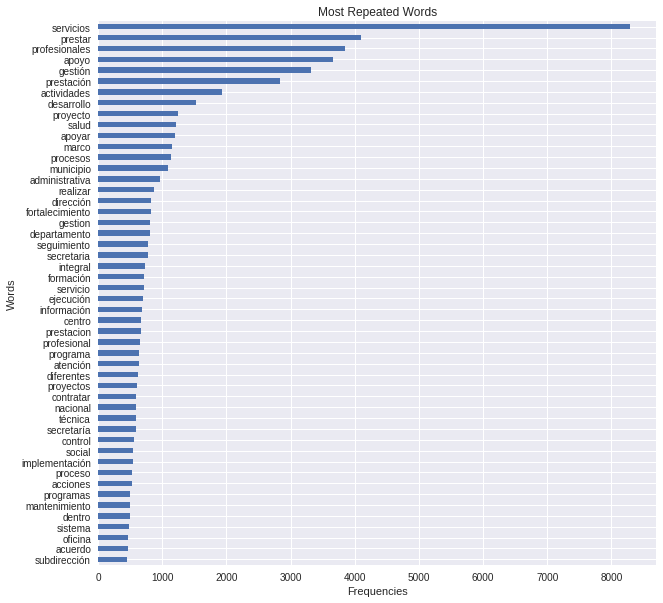

In [21]:
plt.figure(figsize=(10,10))
plt.title('Most Repeated Words')
plt.ylabel('Words')
plt.xlabel('Frequencies')
df_sample.normalize_description.str.split(expand=True).stack().value_counts().iloc[:50].sort_values().plot(kind = 'barh')

In [22]:
def n_gram_representation(data, n_size, k_most=50, plot=True):

    cv = CountVectorizer(ngram_range=(n_size,n_size), analyzer= "word")

    cv_matrix = cv.fit_transform(df_sample.normalize_description)
    
    df = pd.DataFrame(data=cv_matrix.toarray(),columns=cv.get_feature_names())

    def n_gram_barplot(data, k=k_most):
        plt.figure(figsize=(10,10))
        plt.title('Most Repeated {} Grams'.format(n_size))
        plt.ylabel('{} Grams'.format(n_size))
        plt.xlabel('Frequencies')
        data.sum().sort_values(ascending=False).iloc[:k].sort_values().plot(kind = 'barh')

    if plot:

        n_gram_barplot(df)
    
    else:

        return df

/home/lenovo/Documents/daniel/correlation_one/compra_eficiente_unspsc_codes_nlp/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


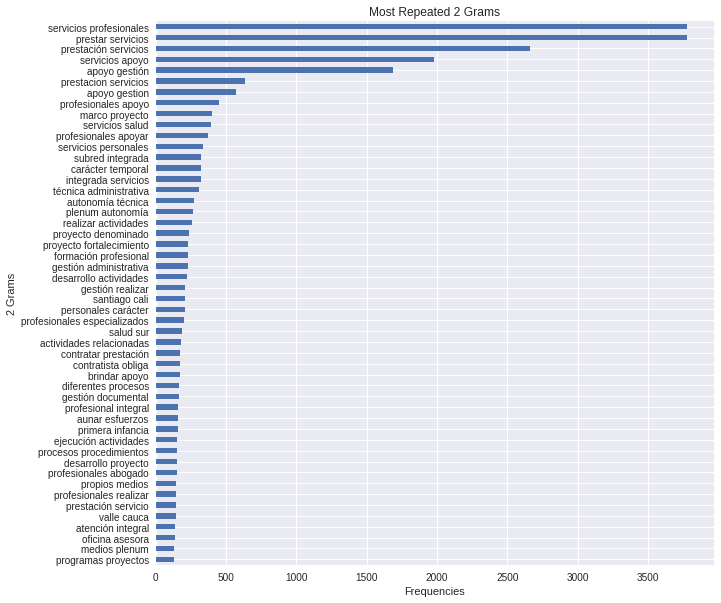

In [23]:
n_gram_representation(df_sample, 2)

/home/lenovo/Documents/daniel/correlation_one/compra_eficiente_unspsc_codes_nlp/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


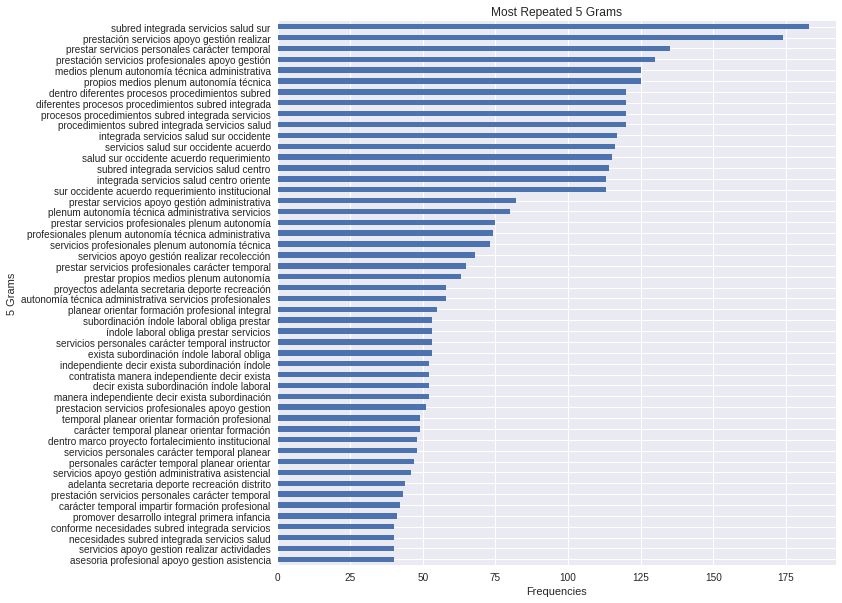

In [24]:
n_gram_representation(df_sample, 5)

/home/lenovo/Documents/daniel/correlation_one/compra_eficiente_unspsc_codes_nlp/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


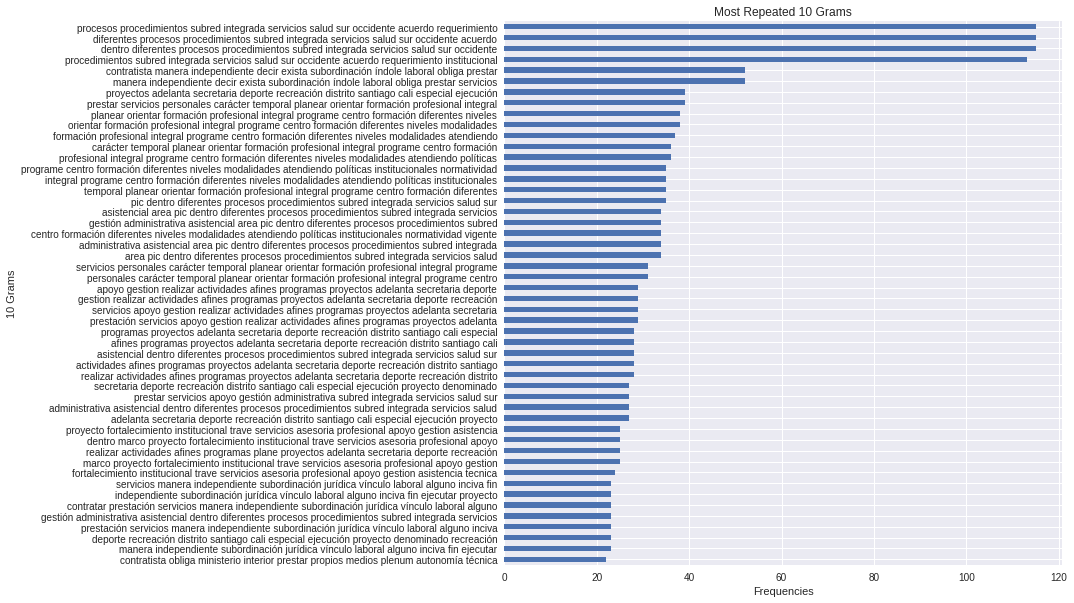

In [25]:
n_gram_representation(df_sample, 10)

/home/lenovo/Documents/daniel/correlation_one/compra_eficiente_unspsc_codes_nlp/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


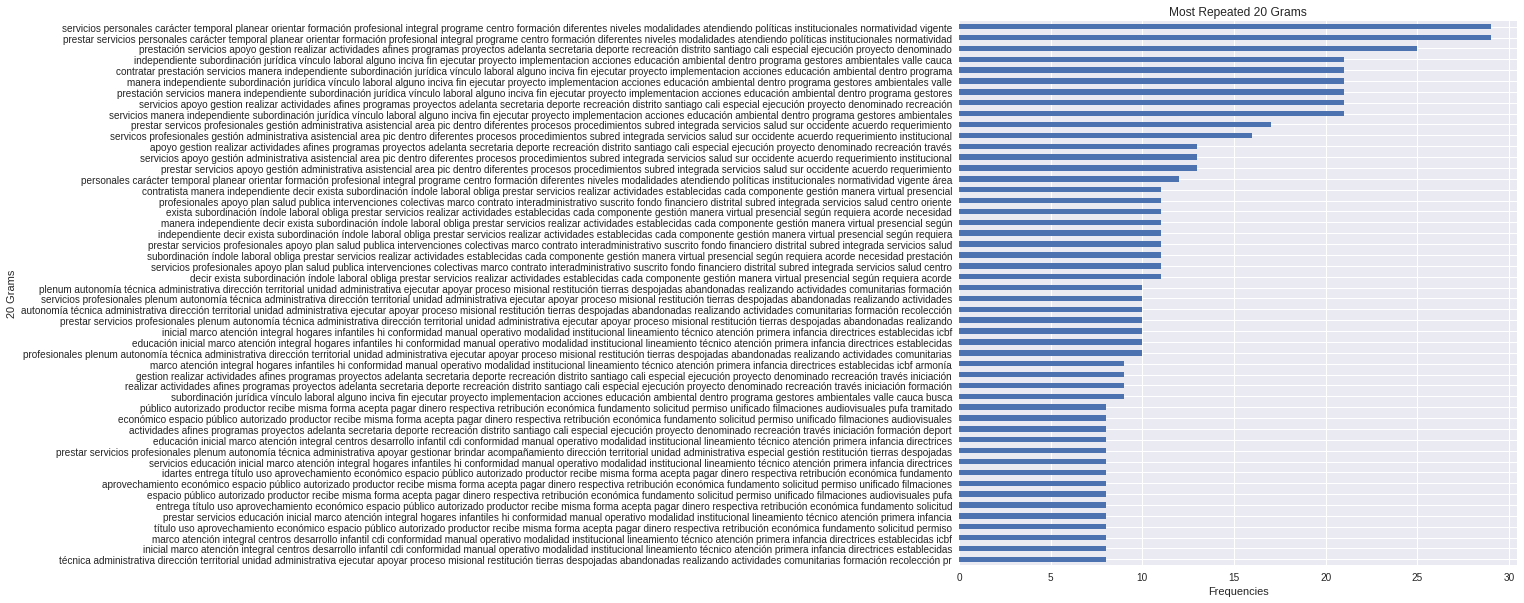

In [26]:
n_gram_representation(df_sample, 20)

/home/lenovo/Documents/daniel/correlation_one/compra_eficiente_unspsc_codes_nlp/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


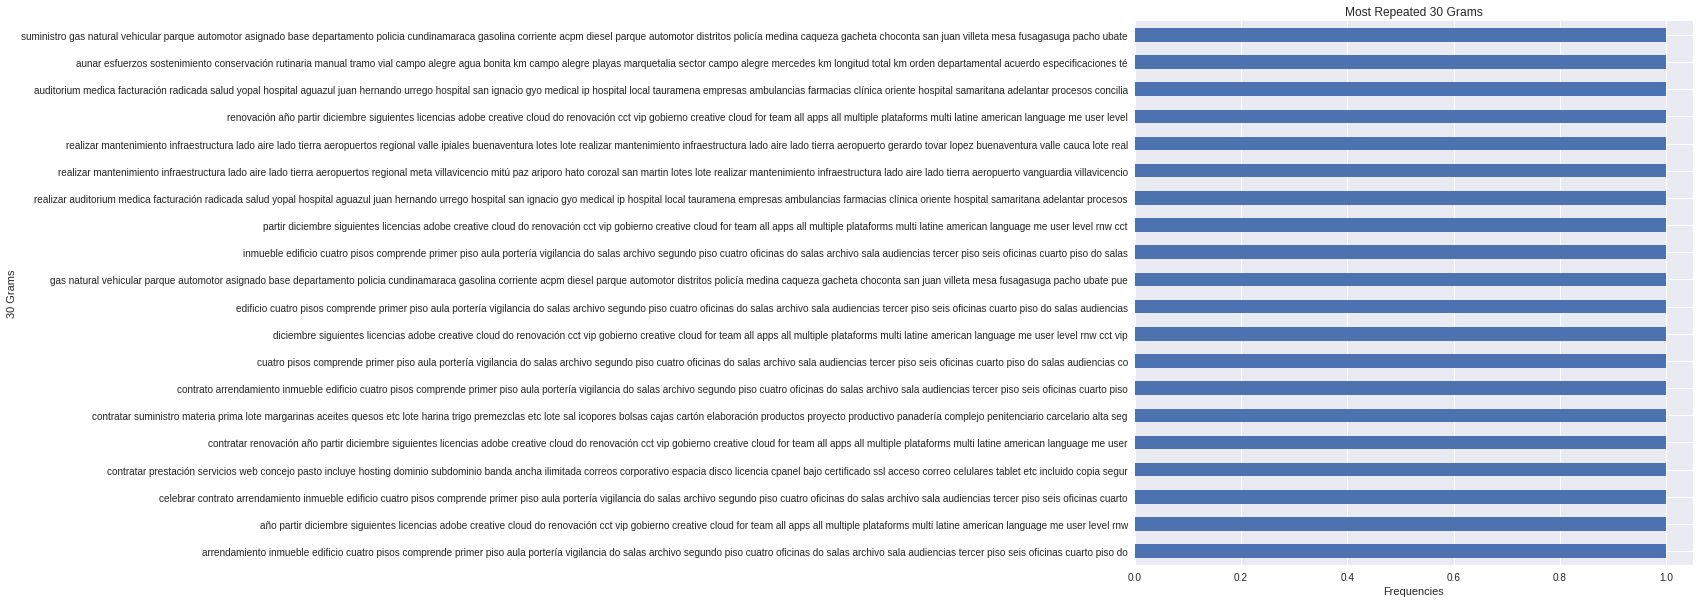

In [27]:
n_gram_representation(df_sample, 30)

This representation of n_gram gives us the size of the window about how many words we could use to get a smaller representation of the text with approximate contract information. We see that the distribution of 5 grams is similar to that of 10 grams, that is, a sentence of 10 words appears in the same number of documents as one of 5, approximately. This agrees with the aforementioned about documents having a short length.